<a href="https://colab.research.google.com/github/apitongcm/Research-Machine-Learning/blob/main/log_analysis_bot_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
sheet_data = "/content/sample_data/NASA Dataset for LSTM.csv"

df = pd.read_csv(sheet_data)

#Data type convesion to float
df["time"] = df["minute"]
df["minute"] = pd.to_datetime(df["minute"], errors="coerce")
df = df.dropna(subset=["minute"])
df["minute"] = (df["minute"] - df["minute"].min()).dt.total_seconds() / 60
print(df["minute"].dtype)


df["count"] = pd.to_numeric(df["count"])
df

float64


,minute,count,time
0,0.0,42,1995-07-01 00:00:00
1,1.0,61,1995-07-01 00:01:00
2,2.0,57,1995-07-01 00:02:00
3,3.0,71,1995-07-01 00:03:00
4,4.0,70,1995-07-01 00:04:00
...,...,...,...
81391,89275.0,30,1995-08-31 23:55:00
81392,89276.0,38,1995-08-31 23:56:00
81393,89277.0,16,1995-08-31 23:57:00
81394,89278.0,17,1995-08-31 23:58:00


In [ ]:
features = ["minute","count"]
X = df[features].astype(float)

#standardization
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

#scaled Dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns = features, index=X.index)

X_scaled_df


,minute,count
0,-1.659923,-0.018199
1,-1.659886,0.636654
2,-1.659848,0.498790
3,-1.659811,0.981314
4,-1.659774,0.946848
...,...,...
81391,1.654097,-0.431791
81392,1.654134,-0.156063
81393,1.654171,-0.914314
81394,1.654208,-0.879848


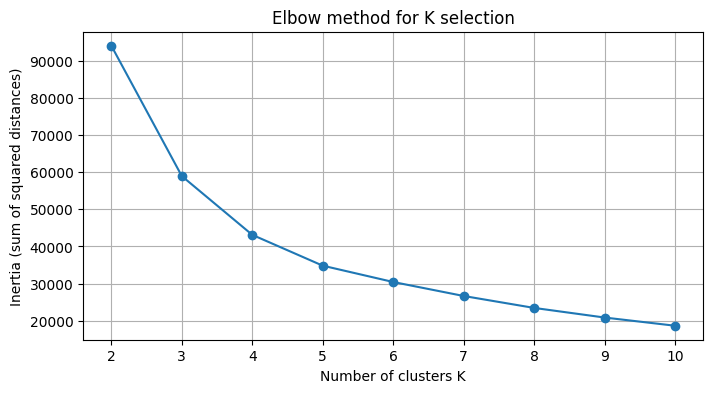

In [ ]:
inertias = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

#ploting
plt.figure(figsize=(8,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow method for K selection")
plt.grid(True)
plt.show()

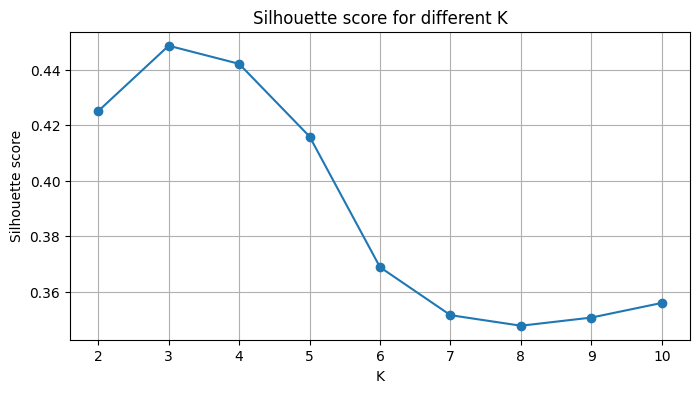

Best K by silhouette: 3 score: 0.448707448842648


In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42,n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))


#plotting
plt.figure(figsize=(8,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette score for different K")
plt.grid(True)
plt.show()

print("Best K by silhouette:", K_range[int(np.argmax(sil_scores))], "score:", max(sil_scores))

In [ ]:
#Based on Elbow Method
selected_K = 3

kmeans = KMeans(n_clusters=selected_K, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(X_scaled)


#Adding original Dataframe
df = df.copy()
df["Cluster"] = cluster_labels
df["Cluster"] = df["Cluster"].astype(int)

#Validation (peek)
print(df["Cluster"].value_counts().sort_index())
df.head()

Cluster
0    37901
1    14122
2    29373
Name: count, dtype: int64


,minute,count,time,KMeans_Cluster,Cluster
0,0.0,42,1995-07-01 00:00:00,2,2
1,1.0,61,1995-07-01 00:01:00,2,2
2,2.0,57,1995-07-01 00:02:00,2,2
3,3.0,71,1995-07-01 00:03:00,1,1
4,4.0,70,1995-07-01 00:04:00,1,1


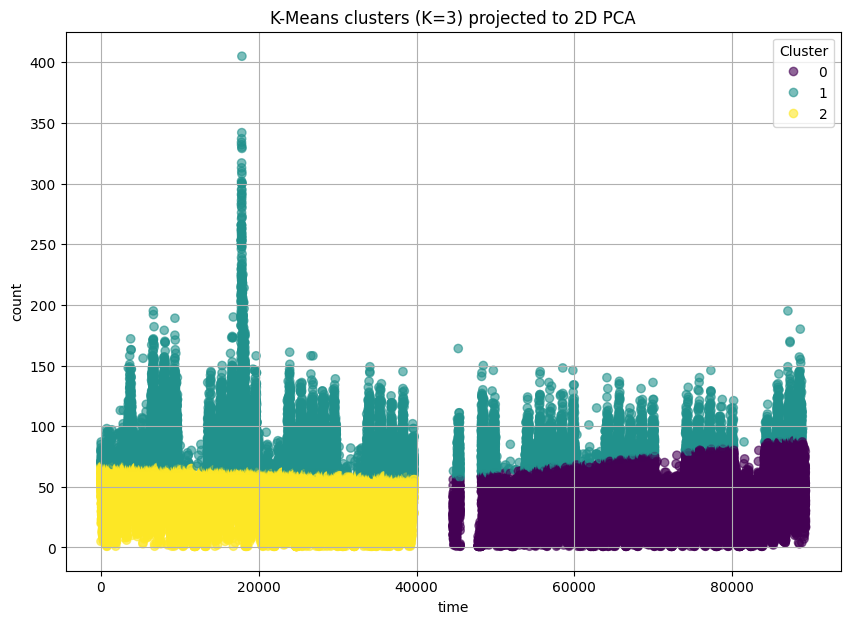

In [ ]:

# Plot clusters in PCA plane
plt.figure(figsize=(10,7))
scatter = plt.scatter(df["minute"], df["count"], c=df["Cluster"], alpha=0.6)
plt.xlabel("time")
plt.ylabel("count")
plt.title(f"K-Means clusters (K={selected_K}) projected to 2D PCA")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)

In [ ]:
cluster_summary = df.groupby("Cluster")[features].agg(["mean", "std", "count"])

cluster_means = df.groupby("Cluster")[features].mean().round(2)
cluster_counts = df["Cluster"].value_counts().sort_index()

print("Cluster counts:\n", cluster_counts)
print("\nCluster means:\n", cluster_means)
print("\nCluster summary:\n", cluster_summary)

Cluster counts:
 Cluster
0    37901
1    14122
2    29373
Name: count, dtype: int64

Cluster means:
            minute  count
Cluster                 
0        68561.82  32.20
1        31977.46  90.32
2        20071.28  32.87

Cluster summary:
                minute                           count                  
                 mean           std  count       mean        std  count
Cluster                                                                
0        68561.817657  12029.030307  37901  32.204375  18.351905  37901
1        31977.456522  23620.331094  14122  90.324671  25.795797  14122
2        20071.282300  11702.726829  29373  32.869268  15.784717  29373


In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination=0.1,  #Adding Assumptions
    random_state=42
)

iso_labels = iso.fit_predict(X_scaled)
df['Isolation_Anomaly'] = iso_labels

df["Iso_Label"] = iso_labels
print(df["Iso_Label"].value_counts())

Iso_Label
 1    73256
-1     8140
Name: count, dtype: int64


In [ ]:
df["cluster_dist"] = kmeans.transform(X_scaled).min(axis=1)

from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()

df["iso_norm"] = norm.fit_transform(df["Isolation_Anomaly"].values.reshape(-1,1))
df["dist_norm"] = norm.fit_transform(df["cluster_dist"].values.reshape(-1,1))

df["combined_score"] = (df["iso_norm"] + df["dist_norm"]) / 2
df


,minute,count,time,KMeans_Cluster,Cluster,Isolation_Anomaly,Iso_Label,cluster_dist,iso_norm,dist_norm,combined_score
0,0.0,42,1995-07-01 00:00:00,2,2,1,1,0.808883,1.0,0.074146,0.537073
1,1.0,61,1995-07-01 00:01:00,2,2,-1,-1,1.222599,0.0,0.112267,0.056133
2,2.0,57,1995-07-01 00:02:00,2,2,-1,-1,1.116453,0.0,0.102486,0.051243
3,3.0,71,1995-07-01 00:03:00,1,1,-1,-1,1.360797,0.0,0.125001,0.062500
4,4.0,70,1995-07-01 00:04:00,1,1,-1,-1,1.377993,0.0,0.126585,0.063293
...,...,...,...,...,...,...,...,...,...,...,...
81391,89275.0,30,1995-08-31 23:55:00,0,0,-1,-1,0.772682,0.0,0.070810,0.035405
81392,89276.0,38,1995-08-31 23:56:00,0,0,1,1,0.794374,1.0,0.072809,0.536404
81393,89277.0,16,1995-08-31 23:57:00,0,0,-1,-1,0.950599,0.0,0.087204,0.043602
81394,89278.0,17,1995-08-31 23:58:00,0,0,-1,-1,0.930785,0.0,0.085378,0.042689


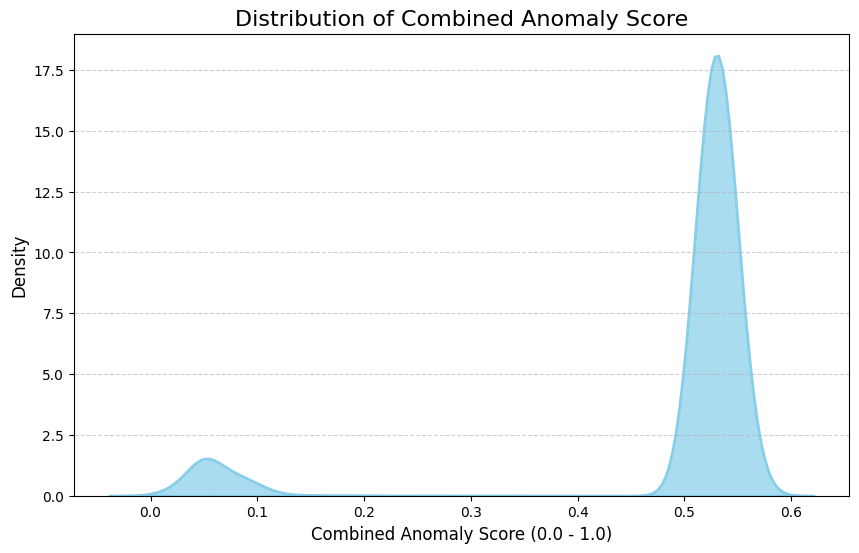

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Distribution of Combined Score (KDE Plot)
plt.figure(figsize=(10, 6))

# A Kernel Density Estimate (KDE) plot is great for showing the shape of the data
sns.kdeplot(df["combined_score"], fill=True, color="skyblue", alpha=0.7, linewidth=2)

plt.title("Distribution of Combined Anomaly Score", fontsize=16)
plt.xlabel("Combined Anomaly Score (0.0 - 1.0)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

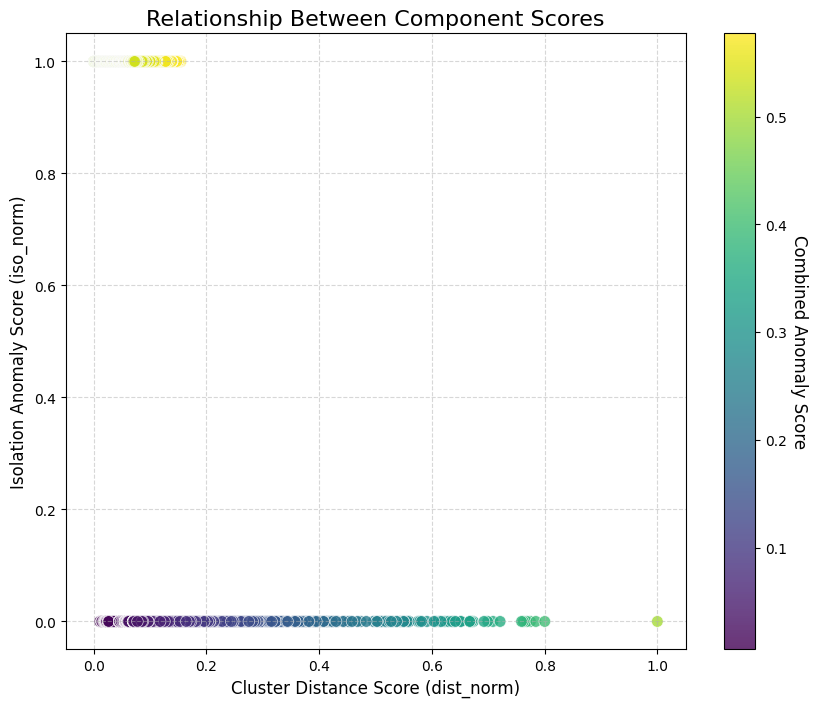

In [ ]:
import matplotlib.pyplot as plt

#Scatter Plot of Component Scores (Colored by Combined Score) ---
plt.figure(figsize=(10, 8))

# Use 'combined_score' for the color (c)
scatter = plt.scatter(df["dist_norm"], df["iso_norm"],
                      c=df["combined_score"], # Use the combined score for color
                      cmap="viridis",         # 'viridis' is a good sequential color scheme
                      s=70,                   # Size of the points
                      alpha=0.8,
                      edgecolor='w', linewidth=0.5)

# Add a color bar to interpret the scores
cbar = plt.colorbar(scatter)
cbar.set_label("Combined Anomaly Score", rotation=270, labelpad=15, fontsize=12)

plt.title("Relationship Between Component Scores", fontsize=16)
plt.xlabel("Cluster Distance Score (dist_norm)", fontsize=12)
plt.ylabel("Isolation Anomaly Score (iso_norm)", fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [ ]:
#function in detecting potential bot based on behavioral pattern in Combined Anonaly Score

def classify_behavior (combined_score, threshold = 0.4):
    return "SUSPICIOUS" if threshold >= combined_score else "NORMAL"

In [ ]:
df['label'] = df['combined_score'].apply(classify_behavior)
df

,minute,count,time,KMeans_Cluster,Cluster,Isolation_Anomaly,Iso_Label,cluster_dist,iso_norm,dist_norm,combined_score,label
0,0.0,42,1995-07-01 00:00:00,2,2,1,1,0.808883,1.0,0.074146,0.537073,NORMAL
1,1.0,61,1995-07-01 00:01:00,2,2,-1,-1,1.222599,0.0,0.112267,0.056133,SUSPICIOUS
2,2.0,57,1995-07-01 00:02:00,2,2,-1,-1,1.116453,0.0,0.102486,0.051243,SUSPICIOUS
3,3.0,71,1995-07-01 00:03:00,1,1,-1,-1,1.360797,0.0,0.125001,0.062500,SUSPICIOUS
4,4.0,70,1995-07-01 00:04:00,1,1,-1,-1,1.377993,0.0,0.126585,0.063293,SUSPICIOUS
...,...,...,...,...,...,...,...,...,...,...,...,...
81391,89275.0,30,1995-08-31 23:55:00,0,0,-1,-1,0.772682,0.0,0.070810,0.035405,SUSPICIOUS
81392,89276.0,38,1995-08-31 23:56:00,0,0,1,1,0.794374,1.0,0.072809,0.536404,NORMAL
81393,89277.0,16,1995-08-31 23:57:00,0,0,-1,-1,0.950599,0.0,0.087204,0.043602,SUSPICIOUS
81394,89278.0,17,1995-08-31 23:58:00,0,0,-1,-1,0.930785,0.0,0.085378,0.042689,SUSPICIOUS


In [ ]:
suspicious_df = df[df['label'] == "SUSPICIOUS"]
suspicious_df

,minute,count,time,KMeans_Cluster,Cluster,Isolation_Anomaly,Iso_Label,cluster_dist,iso_norm,dist_norm,combined_score,label
1,1.0,61,1995-07-01 00:01:00,2,2,-1,-1,1.222599,0.0,0.112267,0.056133,SUSPICIOUS
2,2.0,57,1995-07-01 00:02:00,2,2,-1,-1,1.116453,0.0,0.102486,0.051243,SUSPICIOUS
3,3.0,71,1995-07-01 00:03:00,1,1,-1,-1,1.360797,0.0,0.125001,0.062500,SUSPICIOUS
4,4.0,70,1995-07-01 00:04:00,1,1,-1,-1,1.377993,0.0,0.126585,0.063293,SUSPICIOUS
5,5.0,54,1995-07-01 00:05:00,2,2,-1,-1,1.041672,0.0,0.095596,0.047798,SUSPICIOUS
...,...,...,...,...,...,...,...,...,...,...,...,...
81390,89274.0,17,1995-08-31 23:54:00,0,0,-1,-1,0.930662,0.0,0.085367,0.042683,SUSPICIOUS
81391,89275.0,30,1995-08-31 23:55:00,0,0,-1,-1,0.772682,0.0,0.070810,0.035405,SUSPICIOUS
81393,89277.0,16,1995-08-31 23:57:00,0,0,-1,-1,0.950599,0.0,0.087204,0.043602,SUSPICIOUS
81394,89278.0,17,1995-08-31 23:58:00,0,0,-1,-1,0.930785,0.0,0.085378,0.042689,SUSPICIOUS


Things to ponder
1- What are the common characteristics of the high-scoring sessions?
2- Do they have an unusual number of requests?Are they visiting pages at an impossible speed?
3- Do they use strange $\text{User-Agents}$ or IP addresses from known botnets?

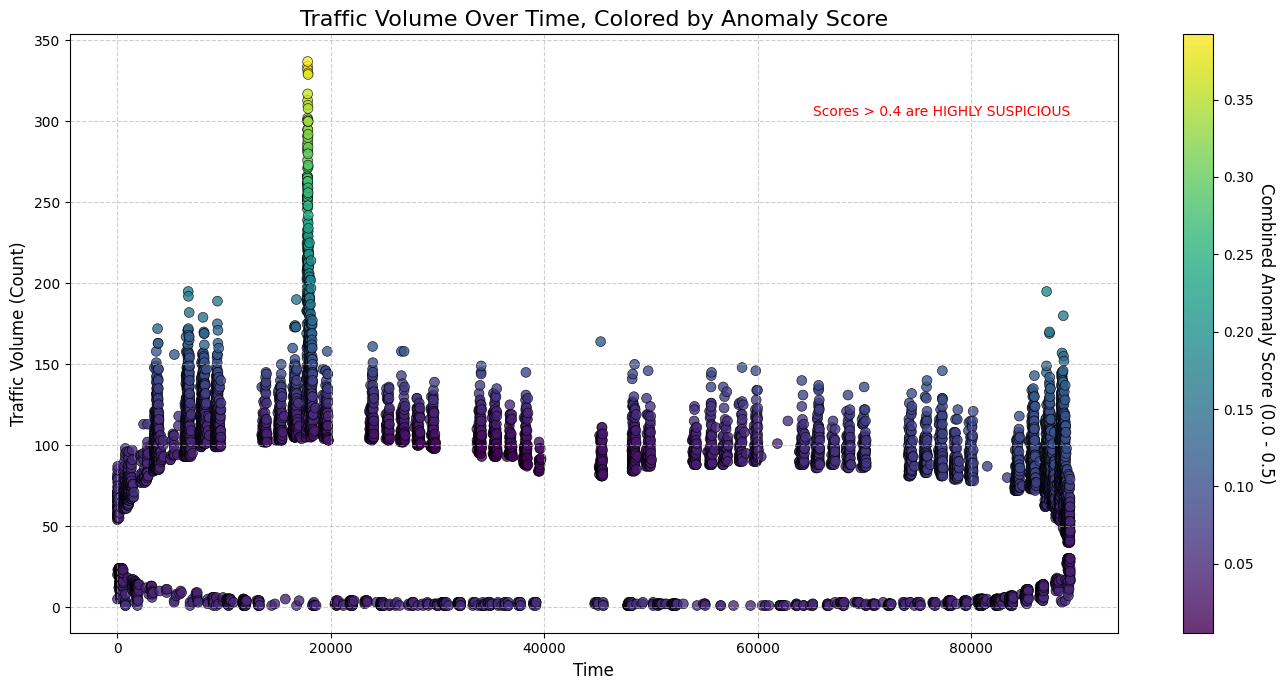

In [ ]:
#Create the Figure and Axes
plt.figure(figsize=(14, 7))

#Scatter Plot: Count over Time, Colored by Score
scatter = plt.scatter(
    x='minute',
    y='count',
    data=suspicious_df,
    c='combined_score',          # Color points by the anomaly score
    cmap='viridis',              # Use the 'viridis' colormap
    s=50,                        # Size of the points
    alpha=0.8,
    edgecolor='k', linewidth=0.5
)

# Add Labels, Title, and Grid
plt.title("Traffic Volume Over Time, Colored by Anomaly Score", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Traffic Volume (Count)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)


#include color bar
cbar = plt.colorbar(scatter)
cbar.set_label("Combined Anomaly Score (0.0 - 0.5)", rotation=270, labelpad=15, fontsize=12)


# A visual reminder of the threshold used in the previous step
plt.text(suspicious_df['minute'].iloc[-1], suspicious_df['count'].max() * 0.9,
         'Scores > 0.4 are HIGHLY SUSPICIOUS',
         fontsize=10, color='red', ha='right')


plt.tight_layout()
plt.show()

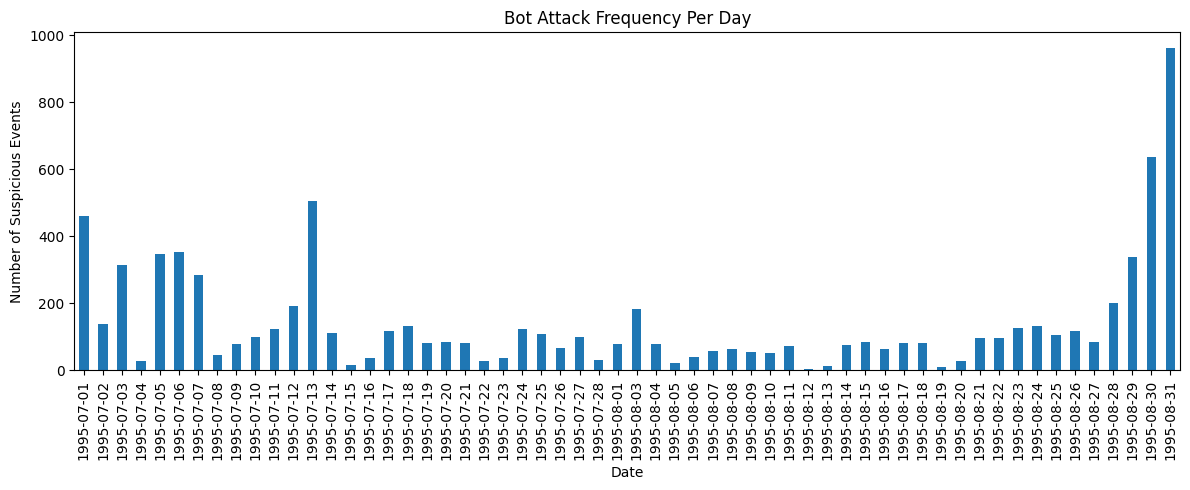

In [ ]:
df['time'] = pd.to_datetime(df['time'])
#df['hour'] = df['time'].dt.floor('H')
df['date'] = df['time'].dt.date
attack_df = df[df['label'] == "SUSPICIOUS"]
attack_counts = attack_df.groupby('date').size()


plt.figure(figsize=(12,5))
attack_counts.plot(kind='bar')

plt.title("Bot Attack Frequency Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Suspicious Events")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

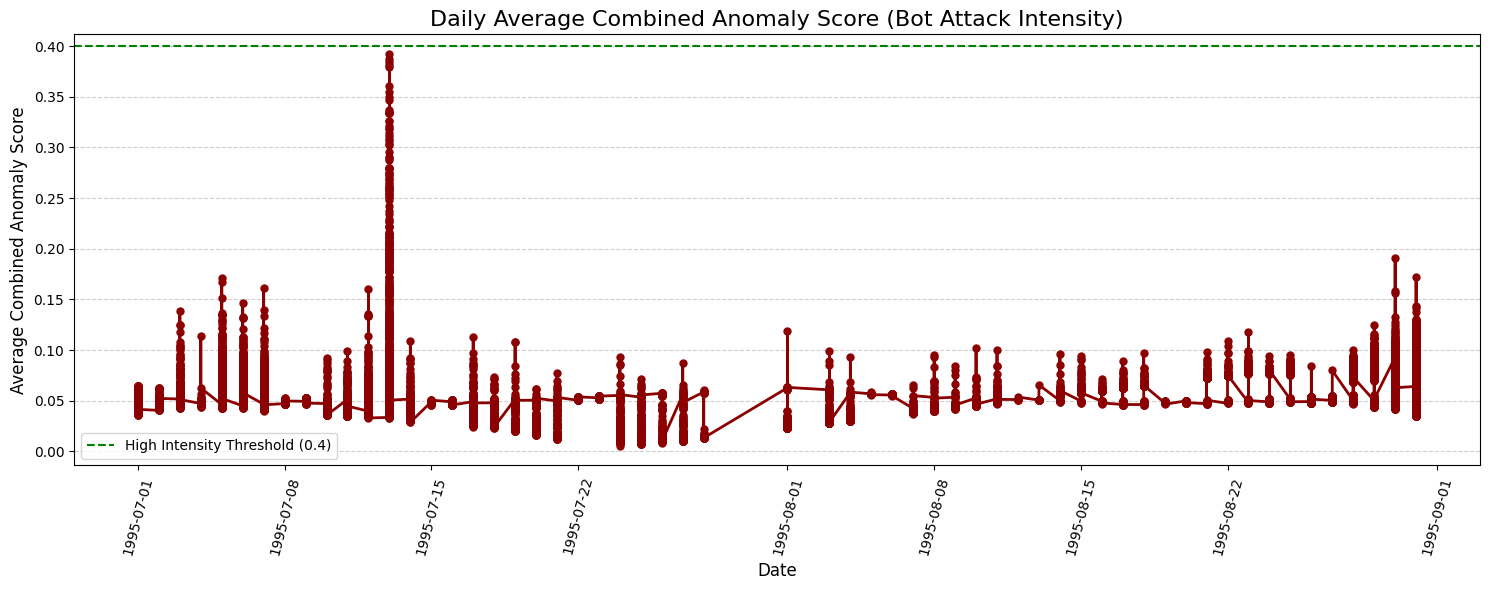

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))

# Plot the average combined score as a line graph
plt.plot(attack_df['date'], attack_df['combined_score'],
         marker='o', linestyle='-', color='darkred', linewidth=2, markersize=5)

# Define the high-intensity anomaly threshold
threshold = 0.4
plt.axhline(y=threshold, color='green', linestyle='--', label=f'High Intensity Threshold ({threshold})')

# Set titles and labels
plt.title("Daily Average Combined Anomaly Score (Bot Attack Intensity)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Combined Anomaly Score", fontsize=12)

# Format the x-axis to show dates clearly
plt.xticks(rotation=75)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()


# plt.show()